# Generative Adversarial Networks for Weakly Supervised Generation and Evaluation of Brain Tumor Segmentations on MR Images
This notebook serves to demonstrate how to train and run the weakly supervised segmentation models proposed in the paper [Generative Adversarial Networks for Weakly Supervised Generation and Evaluation of Brain Tumor Segmentations on MR Images](https://arxiv.org/abs/2211.05269).

## Importing libraries

In [1]:
!pip install --upgrade --quiet gdown # Required otherwise large files cannot be downloaded

In [2]:
# Importing libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import gdown

## Loading preprocessed example MR images from the [BraTS 2020 dataset](https://www.med.upenn.edu/cbica/brats2020/data.html),  corresponding seeds, and pretrained model weights.

In [3]:
gdown.download(f"https://drive.google.com/uc?id=1N6PkBdvUSyfqUpp_e0jL8-Lb0zgZo5Yj&confirm=t", "mr_images.pt")
gdown.download(f"https://drive.google.com/uc?id=1tFJ7MwhwDgEZDCE1w59MganykgtDpL7v&confirm=t", "seeds.pt")
gdown.download(f"https://drive.google.com/uc?id=19qdY48wyDXo22jfAK-1lhvv9PDn7tZmE&confirm=t", "pretrained_model_weights.pt")
gdown.download(f"https://drive.google.com/uc?id=1k50orlAAbVUnXUCploRUuSKC6DRb9arF&confirm=t", "reconstruction_maps.pt")

Downloading...
From: https://drive.google.com/uc?id=1N6PkBdvUSyfqUpp_e0jL8-Lb0zgZo5Yj&confirm=t
To: /content/mr_images.pt
100%|██████████| 1.05M/1.05M [00:00<00:00, 67.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tFJ7MwhwDgEZDCE1w59MganykgtDpL7v&confirm=t
To: /content/seeds.pt
100%|██████████| 263k/263k [00:00<00:00, 83.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=19qdY48wyDXo22jfAK-1lhvv9PDn7tZmE&confirm=t
To: /content/pretrained_model_weights.pt
100%|██████████| 253M/253M [00:02<00:00, 95.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k50orlAAbVUnXUCploRUuSKC6DRb9arF&confirm=t
To: /content/reconstruction_maps.pt
100%|██████████| 263k/263k [00:00<00:00, 63.0MB/s]


'reconstruction_maps.pt'

For demonstration purposes in this notebook only CPU is used. Use the commented code labeled GPU when running with a GPU available.

In [4]:
# mr_images = torch.load("mr_images.pt") # GPU
# seeds = torch.load("seeds.pt") # GPU
# pretrained_model_weights = torch.load("pretrained_model_weights.pt") # GPU
# reconstruction_maps = torch.load("reconstruction_maps.pt") # GPU
mr_images = torch.load("mr_images.pt", map_location=torch.device('cpu'))
seeds = torch.load("seeds.pt", map_location=torch.device('cpu'))
pretrained_model_weights = torch.load("pretrained_model_weights.pt", map_location=torch.device('cpu'))
example_reconstruction_maps = torch.load("reconstruction_maps.pt", map_location=torch.device('cpu'))

<ipython-input-4-24335aebce8c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mr_images = torch.load("mr_images.pt", map_location=torch.device('cpu'))
<ipython-input-4-243

## Defining data specifications

Each image must be of shape (1, 4, H, W), where H and W are 128. This is a single image example but datasets with N images would have shape (N, 4, H, W).

The 4 channels correspond to the following volumes in order:
1.   T2 Fluid Attenuated Inversion Recovery (T2-FLAIR)
2.   Native (T1)
3.   Post-contrast T1-weighted (T1Gd)
4.   T2-weighted (T2)

Details on the preprocessing can be found in the [paper](https://arxiv.org/abs/2209.09930).

Demonstrating the shape of a single sample.

In [5]:
print("Shape of a data sample:", mr_images[0:1].shape)

Shape of a data sample: torch.Size([1, 4, 128, 128])


Visualizing the preprocessed images.

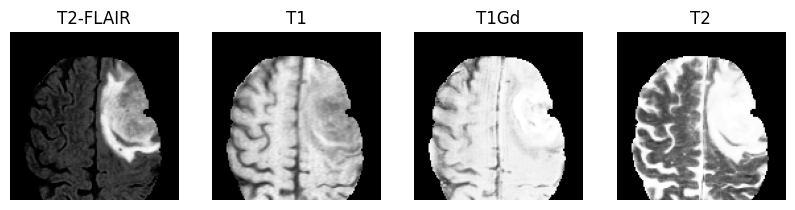

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(10, 10))
channel_names = ["T2-FLAIR", "T1", "T1Gd", "T2"]
for channel_idx in range(4):
  axs[channel_idx].imshow(mr_images[0, channel_idx], cmap='gray')
  axs[channel_idx].set_title(channel_names[channel_idx])
  axs[channel_idx].axis('off')
plt.show()

The seeds were generated using [Randomized Input Sampling for Explanation of Black-box Models](https://arxiv.org/abs/1806.07421) from a classifier trained on binary image-level labels indicating whether or not the input images are cancerous. More details can be found in the [paper](https://arxiv.org/abs/2209.09930).

Each of the two channels are binary maps. The first channel corresponds to positive seeds (high likelihood of tumors). The second channel correspond to negative seeds (low likelihood of tumors).

Demonstrating the shape of the seeds for a single data sample.

In [7]:
print("Shape of seeds for a data sample:", seeds[0:1].shape)

Shape of seeds for a data sample: torch.Size([1, 2, 128, 128])


Visualizing the corresponding seeds (green: positive seeds, magenta: negative seeds, black: uncertain regions).

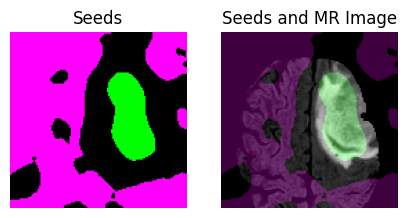

In [8]:
seed_visualization = torch.stack((seeds[0, 1], seeds[0, 0], seeds[0, 1]), dim=-1).type(torch.uint8) * 255
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
axs[0].imshow(seed_visualization)
axs[0].set_title("Seeds")
axs[0].axis('off')
axs[1].imshow(mr_images[0, 0], cmap='gray')
axs[1].imshow(seed_visualization, alpha=0.25)
axs[1].set_title("Seeds and MR Image")
axs[1].axis('off')
plt.show()

## Training generator
The first step of this work is to pretrain the generator component of the U-Net using healthy images.

### Defining generator and discriminator architectures

In [9]:
# ngf is a parameter that is used to determine the architecture size and informs the size of other relevant variables.
ngf = 64

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class dcgan_generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=1):
        super(dcgan_generator, self).__init__()
        # Blocks
        #####################
        # state size. (ngf*16) x 4 x 4
        self.block0 = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
        )

        # state size. (ngf*8) x 8 x 8
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
        )

        # state size. (ngf*4) x 16 x 16
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
        )

        # state size. (ngf*2) x 32 x 32
        self.block3 = nn.Sequential(
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
        )

        # state size. (ngf) x 64 x 64
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
        )

        # state size. (nc) x 128 x 128
        self.block5 = nn.Sequential(
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )
        #####################

        '''
        # Skip connections
        #####################
        # state size. (ngf*8) x 4 x 4
        self.skip1 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 16 * 2, out_channels=ngf * 16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )

        # state size. (ngf*4) x 8 x 8
        self.skip2 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 8 * 2, out_channels=ngf * 8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )

        # state size. (ngf*2) x 16 x 16
        self.skip3 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 4 * 2, out_channels=ngf * 4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )

        # state size. (ngf) x 32 x 32
        self.skip4 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 2 * 2, out_channels=ngf * 2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        #####################
        '''


    def forward(self, z0, z1, z2, z3, z4):
        in0 = z0
        out0 = self.block0(z0)

        # in1 = self.skip1(torch.cat((out0, z1), 1))
        in1 = out0
        out1 = self.block1(in1)

        # in2 = self.skip2(torch.cat((out1, z2), 1))
        in2 = out1
        out2 = self.block2(in2)

        # in3 = self.skip3(torch.cat((out2, z3), 1))
        in3 = out2
        out3 = self.block3(in3)

        # in4 = self.skip4(torch.cat((out3, z4), 1))
        in4 = out3
        out4 = self.block4(in4)

        in5 = out4
        out5 = self.block5(in5)

        return out5

class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input)

### Training example

Initiailizing the models for training.

In [11]:
generator = dcgan_generator(ngf=ngf)
generator.apply(weights_init)
generator.train()

image_discriminator = Discriminator()
image_discriminator.apply(weights_init)
image_discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

Extracting FLAIR channel.

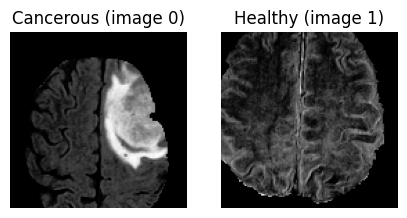

In [12]:
# For this demonstrative example, the first image is cancerous and the second image is healthy.

fig, axs = plt.subplots(1, 2, figsize=(5, 5))
image_names = ["Cancerous (image 0)", "Healthy (image 1)"]
for image_idx in range(2):
  axs[image_idx].imshow(mr_images[image_idx, 0], cmap='gray')
  axs[image_idx].set_title(image_names[image_idx])
  axs[image_idx].axis('off')
plt.show()

# In addition, when training the GAN, we only use the FLAIR channel. We will use the other channels when training the segmentation model.
gan_training_mr_images = mr_images[:, 0:1, :, :]

Defining loss functions.

In [13]:
bce_func = nn.BCEWithLogitsLoss()

Preparing training hyperparameters, dataset, optimizer, and scheduler.

In [14]:
# Training hyperparameters
num_epochs = 1 # For demonstration purposes
generator_initial_learning_rate = 0.0002
image_discriminator_initial_learning_rate = 0.0002
batch_size = 1 # For demonstration purposes
use_cuda = False # For demonstration purposes

In [15]:
# Dataset
class generator_dataset(Dataset):
    def __init__(self, data):
        super().__init__()
        # data is (N, 4, H, W)

        self.num_data = len(data)
        self.data = data.float()

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = generator_dataset(gan_training_mr_images)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, drop_last=True, shuffle=True)

In [16]:
# Optimizer and scheduler
generator_optimizer = torch.optim.Adam(lr=generator_initial_learning_rate, params=generator.parameters(), betas=(0.5, 0.999))
generator_scheduler = torch.optim.lr_scheduler.StepLR(generator_optimizer, step_size=num_epochs // 2, gamma=0.5)
image_discriminator_optimizer = torch.optim.Adam(lr=image_discriminator_initial_learning_rate, params=image_discriminator.parameters(), betas=(0.5, 0.999))
image_discriminator_scheduler = torch.optim.lr_scheduler.StepLR(image_discriminator_optimizer, step_size=num_epochs // 2, gamma=0.5)

In [17]:
# Labels
trick_image_labels = torch.ones(batch_size, 1, 1, 1)
real_image_labels = torch.ones(batch_size, 1, 1, 1) * 0.9 # Applying smooth labels
fake_image_labels = torch.ones(batch_size, 1, 1, 1) * 0.1 # Applying smooth labels
if use_cuda:
    trick_image_labels = trick_image_labels.cuda()
    real_image_labels = real_image_labels.cuda()
    fake_image_labels = fake_image_labels.cuda()

Training loop.

In [18]:
for epoch in range(0, num_epochs):
    for batch, data in enumerate(train_dataloader):
        if use_cuda:
            data = data.cuda()

        # Generating masked data
        # For custom U-Net architecture and directly outputting healthy brain image
        noise0 = torch.randn(batch_size, 100, 1, 1)
        noise1 = torch.randn(batch_size, ngf * 16, 4, 4)
        noise2 = torch.randn(batch_size, ngf * 8, 8, 8)
        noise3 = torch.randn(batch_size, ngf * 4, 16, 16)
        noise4 = torch.randn(batch_size, ngf * 2, 32, 32)
        if use_cuda:
            noise0 = noise0.cuda()
            noise1 = noise1.cuda()
            noise2 = noise2.cuda()
            noise3 = noise3.cuda()
            noise4 = noise4.cuda()
        generated_data = generator(noise0, noise1, noise2, noise3, noise4)

        # Training image discriminator
        ################################################
        image_discriminator.zero_grad(set_to_none=True)

        # Discriminator on real
        image_discriminator_real_predictions = image_discriminator(data)
        real_image_discriminator_loss = bce_func(image_discriminator_real_predictions, real_image_labels)
        real_image_discriminator_loss.backward()

        # Discriminator on fake
        image_discriminator_fake_predictions = image_discriminator(generated_data.detach())
        fake_image_discriminator_loss = bce_func(image_discriminator_fake_predictions, fake_image_labels)
        fake_image_discriminator_loss.backward()

        # Discriminator optimization
        image_discriminator_optimizer.step()
        ################################################

        # Training generator
        ################################################
        generator.zero_grad(set_to_none=True)
        # tumor_discriminator_trick_predictions = tumor_discriminator(generated_data)
        image_discriminator_trick_predictions = image_discriminator(generated_data)
        # tumor_discriminator_trick_loss = bce_func(tumor_discriminator_trick_predictions, trick_tumor_labels)
            # Reward generator if it tricks the tumor discriminator into thinking there is no tumor
        image_discriminator_trick_loss = bce_func(image_discriminator_trick_predictions, trick_image_labels)
            # Reward generator if it tricks the image_discriminator into thinking the generated data is real

        # seed_loss = generator_loss_func(data, generated_data_logit, seed_labels)

        # generator_loss = (tumor_discriminator_trick_loss + image_discriminator_trick_loss) / 2
        generator_loss = image_discriminator_trick_loss
        # generator_loss += seed_loss # * seed_scale
        generator_loss.backward()

        # Generator optimizer
        generator_optimizer.step()

    # generator_scheduler.step() # Because this example uses num_epochs=1, the step_size argument in the scheduler definition becomes 0, which results with an error when the scheduler.step() is called.
        # The line above should be uncommented when num_epochs >= 2. Alternatively, the step size argument could be updated accordingly.
    # image_discriminator_scheduler.step() # Because this example uses num_epochs=1, the step_size argument in the scheduler definition becomes 0, which results with an error when the scheduler.step() is called.
        # The line above should be uncommented when num_epochs >= 2. Alternatively, the step size argument could be updated accordingly.

In [19]:
torch.save(generator.state_dict(), "generator_pretrain_weights.pt")

## U-Net training

### Defining U-Net and discriminator architectures with generator initialization

In [20]:
# ngf is a parameter that is used to determine the architecture size and informs the size of other relevant variables.
ngf = 64

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class dcgan_generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=1):
        super(dcgan_generator, self).__init__()
        # Blocks
        #####################
        # state size. (ngf*16) x 4 x 4
        self.block0 = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
        )

        # state size. (ngf*8) x 8 x 8
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
        )

        # state size. (ngf*4) x 16 x 16
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
        )

        # state size. (ngf*2) x 32 x 32
        self.block3 = nn.Sequential(
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
        )

        # state size. (ngf) x 64 x 64
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
        )

        # state size. (nc) x 128 x 128
        self.block5 = nn.Sequential(
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )
        #####################

    def forward(self, z0, z1, z2, z3, z4):
        in0 = z0
        out0 = self.block0(z0)

        # in1 = self.skip1(torch.cat((out0, z1), 1))
        in1 = out0
        out1 = self.block1(in1)

        # in2 = self.skip2(torch.cat((out1, z2), 1))
        in2 = out1
        out2 = self.block2(in2)

        # in3 = self.skip3(torch.cat((out2, z3), 1))
        in3 = out2
        out3 = self.block3(in3)

        # in4 = self.skip4(torch.cat((out3, z4), 1))
        in4 = out3
        out4 = self.block4(in4)

        in5 = out4
        out5 = self.block5(in5)

        return out5

class Encoder(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Encoder, self).__init__()

        # input is (nc) x 128 x 128
        self.encoder_block0 = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # state size. (ndf) x 64 x 64
        self.encoder_block1 = nn.Sequential(
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # state size. (ndf*2) x 32 x 32
        self.encoder_block2 = nn.Sequential(
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # state size. (ndf*2) x 16 x 16
        self.encoder_block3 = nn.Sequential(
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # state size. (ndf*4) x 8 x 8
        self.encoder_block4 = nn.Sequential(
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # state size. (ndf*8) x 4 x 4
        self.encoder_block5 = nn.Sequential(
            nn.Conv2d(ndf * 16, 100, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        encoder_out0 = self.encoder_block0(input)
        encoder_out1 = self.encoder_block1(encoder_out0)
        encoder_out2 = self.encoder_block2(encoder_out1)
        encoder_out3 = self.encoder_block3(encoder_out2)
        encoder_out4 = self.encoder_block4(encoder_out3)
        encoder_out5 = self.encoder_block5(encoder_out4)

        return encoder_out5, encoder_out4, encoder_out3, encoder_out2, encoder_out1

class NormalizingFlow(nn.Module):
    def __init__(self, generator, encoder):
        super(NormalizingFlow, self).__init__()

        self.generator = generator
        self.encoder = encoder

        # Skip connections
        #####################
        # state size. (ngf*8) x 4 x 4
        self.preskip1 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 16, out_channels=ngf * 16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        self.skip1 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 16 * 2, out_channels=ngf * 16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )

        # state size. (ngf*4) x 8 x 8
        self.preskip2 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        self.skip2 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 8 * 2, out_channels=ngf * 8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )

        # state size. (ngf*2) x 16 x 16
        self.preskip3 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 4, out_channels=ngf * 4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        self.skip3 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 4 * 2, out_channels=ngf * 4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )

        # state size. (ngf) x 32 x 32
        self.preskip4 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 2, out_channels=ngf * 2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        self.skip4 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 2 * 2, out_channels=ngf * 2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        #####################

    def forward(self, input):
        z0, z1, z2, z3, z4 = self.encoder(input)

        in0 = z0
        out0 = self.generator.block0(z0)

        in1 = self.skip1(torch.cat((out0, self.preskip1(z1)), 1))
        out1 = self.generator.block1(in1)

        in2 = self.skip2(torch.cat((out1, self.preskip2(z2)), 1))
        out2 = self.generator.block2(in2)

        in3 = self.skip3(torch.cat((out2, self.preskip3(z3)), 1))
        out3 = self.generator.block3(in3)

        in4 = self.skip4(torch.cat((out3, self.preskip4(z4)), 1))
        out4 = self.generator.block4(in4)

        in5 = out4
        out5 = self.generator.block5(in5)

        return out5, z0

class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input)

### Training example

Initiailizing the models for training.

In [22]:
generator = dcgan_generator(ngf=ngf)
generator.load_state_dict(torch.load("generator_pretrain_weights.pt"))

encoder = Encoder()
encoder.apply(weights_init)
encoder.train()

# Normalizing flow is the U-Net
normalizing_flow = NormalizingFlow(generator, encoder)
normalizing_flow.train()

image_discriminator = Discriminator()
image_discriminator.apply(weights_init)
image_discriminator.train()

<ipython-input-22-a088c6d0da0e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator_pretrain_weights.pt"))


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

Defining loss functions.

In [23]:
class ReconstructionLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(ReconstructionLoss, self).__init__()

        self.l1_func = nn.L1Loss(reduction='none')

    def forward(self, generated_data, data, targets, smooth=1):
        # generated_data_logit is the input
        # data is "ground truth"
        # targets is the seeds indicating where to consider the loss
            # targets is 1 where there is almost definitely no tumor, which is where we want to consider and compare
        # This loss is basically saying that where there is almost definitely no tumor, the generated data should look the same as the input data

        l1_loss = self.l1_func(generated_data, data) * targets
        numerator = torch.sum(l1_loss, dim=(-1, -2, -3))
        denominator = torch.sum(targets, dim=(-1, -2, -3))
        seed_loss_batches = numerator / denominator
        seed_loss = seed_loss_batches.mean()

        return seed_loss

reconstruction_loss_func = ReconstructionLoss()
bce_func = nn.BCEWithLogitsLoss()

Preparing training hyperparameters, dataset, optimizer, and scheduler.

In [24]:
# Training hyperparameters
num_epochs = 1 # For demonstration purposes
normalizing_flow_initial_learning_rate = 0.00002
image_discriminator_initial_learning_rate = 0.00002
reconstruction_scale = 10
gan_scale = 0.05
kl_scale = 1
batch_size = 1 # For demonstration purposes
use_cuda = False # For demonstration purposes

In [25]:
# Dataset
class unet_dataset(Dataset):
    def __init__(self, data, seed_labels, true_data):
        super().__init__()
        # data is (N, 4, H, W)

        self.num_data = len(data)
        self.data = data.float()
        self.seed_labels = seed_labels.float()
        self.true_data = true_data.float()
        self.num_true_data = len(self.true_data)

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        return self.data[idx] , self.seed_labels[idx], self.true_data[idx % self.num_true_data]

# When preparing the dataset, the cancerous images, the negative seeds for the cancerous images, and the healthy images must be separated
cancerous_unet_images = gan_training_mr_images[0:1]
healthy_unet_images = gan_training_mr_images[1:2]
negative_cancerous_seeds = seeds[0:1, 1:2]

train_dataset = unet_dataset(cancerous_unet_images, negative_cancerous_seeds, healthy_unet_images)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, drop_last=True, shuffle=True)

In [26]:
# Optimizer and scheduler
normalizing_flow_optimizer = torch.optim.Adam(lr=normalizing_flow_initial_learning_rate, params=normalizing_flow.parameters(), betas=(0.5, 0.999))
normalizing_flow_scheduler = torch.optim.lr_scheduler.StepLR(normalizing_flow_optimizer, step_size=num_epochs // 4, gamma=0.5)
image_discriminator_optimizer = torch.optim.Adam(lr=image_discriminator_initial_learning_rate, params=image_discriminator.parameters(), betas=(0.5, 0.999))
image_discriminator_scheduler = torch.optim.lr_scheduler.StepLR(image_discriminator_optimizer, step_size=num_epochs // 4, gamma=0.5)

In [27]:
# Define labels
trick_image_labels = torch.ones(batch_size, 1, 1, 1)
real_image_labels = torch.ones(batch_size, 1, 1, 1) * 0.9
fake_image_labels = torch.ones(batch_size, 1, 1, 1) * 0.1
if use_cuda:
    trick_image_labels = trick_image_labels.cuda()
    real_image_labels = real_image_labels.cuda()
    fake_image_labels = fake_image_labels.cuda()

Training loop.

In [28]:
for epoch in range(0, num_epochs):
    for batch, (data, seed_labels, true_images) in enumerate(train_dataloader):
        if use_cuda:
            data = data.cuda()
            seed_labels = seed_labels.cuda()
            true_images = true_images.cuda()

        generated_data, encodings = normalizing_flow(data)

        # Training image discriminator
        ################################################
        image_discriminator.zero_grad(set_to_none=True)

        # Discriminator on real
        image_discriminator_real_predictions = image_discriminator(true_images)
        real_image_discriminator_loss = bce_func(image_discriminator_real_predictions, real_image_labels)
        real_image_discriminator_loss.backward()

        # Discriminator on fake
        image_discriminator_fake_predictions = image_discriminator(generated_data.detach())
        fake_image_discriminator_loss = bce_func(image_discriminator_fake_predictions, fake_image_labels)
        fake_image_discriminator_loss.backward()

        # Discriminator optimization
        image_discriminator_optimizer.step()
        ################################################

        # Training normalizing flow
        ################################################
        normalizing_flow.zero_grad(set_to_none=True)

        mu = encodings.mean()
        std = encodings.std()
        kl_loss = -0.5 * torch.sum((2 * torch.log(std)) - (std ** 2) - (mu ** 2) + 1)
        reconstruction_loss = reconstruction_loss_func(generated_data, data, seed_labels)
        image_discriminator_trick_predictions = image_discriminator(generated_data)
        image_discriminator_trick_loss = bce_func(image_discriminator_trick_predictions, trick_image_labels)

        normalizing_flow_loss = (kl_scale * kl_loss) + (reconstruction_scale * reconstruction_loss) + (gan_scale * image_discriminator_trick_loss)
        normalizing_flow_loss.backward()
        normalizing_flow_optimizer.step()
        ################################################

    # normalizing_flow_scheduler.step() # Because this example uses num_epochs=1, the step_size argument in the scheduler definition becomes 0, which results with an error when the scheduler.step() is called.
        # The line above should be uncommented when num_epochs >= 4. Alternatively, the step size argument could be updated accordingly.
    # image_discriminator_scheduler.step() # Because this example uses num_epochs=1, the step_size argument in the scheduler definition becomes 0, which results with an error when the scheduler.step() is called.
        # The line above should be uncommented when num_epochs >= 4. Alternatively, the step size argument could be updated accordingly.

## Generating differences between cancerous images and their non-cancerous variants

The maps of differences are referred to as reconstruction maps in the code.

Define L1 function to compute the differences.

In [29]:
l1_func = nn.L1Loss(reduction='none')

Use trained U-Net to generate non-cancerous variants of cancerous images and reconstruction maps using the non-cancerous variants.

In [30]:
# normalizing_flow.cuda() # GPU
normalizing_flow.eval()
# l1_func(cancerous_unet_images.cuda(), normalizing_flow(cancerous_unet_images.float().cuda())[0]).detach().cpu() # GPU
reconstruction_map_cancerous = l1_func(cancerous_unet_images, normalizing_flow(cancerous_unet_images.float())[0]).detach().cpu()

def minmax_scale(data):
    b, h, w = data.shape

    data_flatten = data.view(b, -1)

    data_min = data_flatten.min(1, keepdim=True)[0]
    data_max = data_flatten.max(1, keepdim=True)[0]

    data_flatten -= data_min
    data_flatten /= data_max - data_min

    data_unflatten = data_flatten.view(b, h, w)

    return data_unflatten

# Min-max scale the reconstruction maps
    # Note that the expected shape of the reconstruction maps being passed into the minmax_scale() function is (N, 1, H, W) where N is assumed to be greater than 0. In this case, N is not greater than 0, so an unsqueeze(0) is applied after the squeeze() to replicate not squeezing the N channel
reconstruction_map_cancerous = minmax_scale(reconstruction_map_cancerous.squeeze().unsqueeze(0)).unsqueeze(1)

# Reconstruction maps for non-cancerous maps are empty
reconstruction_maps_noncancerous = torch.zeros(len(healthy_unet_images), reconstruction_map_cancerous.shape[1], reconstruction_map_cancerous.shape[2], reconstruction_map_cancerous.shape[3])

reconstruction_maps = torch.cat((reconstruction_map_cancerous, reconstruction_maps_noncancerous), dim=0)

## Training segmentation model

### Defining segmentation model architecture.

In [31]:
class dcgan_generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=1):
        super(dcgan_generator, self).__init__()
        # Blocks
        #####################
        # state size. (ngf*16) x 4 x 4
        self.block0 = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
        )

        # state size. (ngf*8) x 8 x 8
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
        )

        # state size. (ngf*4) x 16 x 16
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
        )

        # state size. (ngf*2) x 32 x 32
        self.block3 = nn.Sequential(
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
        )

        # state size. (ngf) x 64 x 64
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
        )

        # state size. (nc) x 128 x 128
        self.block5 = nn.Sequential(
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
        )
        #####################

    def forward(self, z0, z1, z2, z3, z4):
        in0 = z0
        out0 = self.block0(z0)

        # in1 = self.skip1(torch.cat((out0, z1), 1))
        in1 = out0
        out1 = self.block1(in1)

        # in2 = self.skip2(torch.cat((out1, z2), 1))
        in2 = out1
        out2 = self.block2(in2)

        # in3 = self.skip3(torch.cat((out2, z3), 1))
        in3 = out2
        out3 = self.block3(in3)

        # in4 = self.skip4(torch.cat((out3, z4), 1))
        in4 = out3
        out4 = self.block4(in4)

        in5 = out4
        out5 = self.block5(in5)

        return out5

class Encoder(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Encoder, self).__init__()

        # input is (nc) x 128 x 128
        self.encoder_block0 = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # state size. (ndf) x 64 x 64
        self.encoder_block1 = nn.Sequential(
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # state size. (ndf*2) x 32 x 32
        self.encoder_block2 = nn.Sequential(
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # state size. (ndf*2) x 16 x 16
        self.encoder_block3 = nn.Sequential(
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # state size. (ndf*4) x 8 x 8
        self.encoder_block4 = nn.Sequential(
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # state size. (ndf*8) x 4 x 4
        self.encoder_block5 = nn.Sequential(
            nn.Conv2d(ndf * 16, 100, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        encoder_out0 = self.encoder_block0(input)
        encoder_out1 = self.encoder_block1(encoder_out0)
        encoder_out2 = self.encoder_block2(encoder_out1)
        encoder_out3 = self.encoder_block3(encoder_out2)
        encoder_out4 = self.encoder_block4(encoder_out3)
        encoder_out5 = self.encoder_block5(encoder_out4)

        return encoder_out5, encoder_out4, encoder_out3, encoder_out2, encoder_out1

class NormalizingFlow(nn.Module):
    def __init__(self, generator, encoder):
        super(NormalizingFlow, self).__init__()

        self.generator = generator
        self.encoder = encoder

        # Skip connections
        #####################
        # state size. (ngf*8) x 4 x 4
        self.preskip1 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 16, out_channels=ngf * 16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        self.skip1 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 16 * 2, out_channels=ngf * 16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )

        # state size. (ngf*4) x 8 x 8
        self.preskip2 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        self.skip2 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 8 * 2, out_channels=ngf * 8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )

        # state size. (ngf*2) x 16 x 16
        self.preskip3 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 4, out_channels=ngf * 4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        self.skip3 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 4 * 2, out_channels=ngf * 4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )

        # state size. (ngf) x 32 x 32
        self.preskip4 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 2, out_channels=ngf * 2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        self.skip4 = nn.Sequential(
            nn.Conv2d(in_channels=ngf * 2 * 2, out_channels=ngf * 2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        #####################

    def forward(self, input):
        z0, z1, z2, z3, z4 = self.encoder(input)

        in0 = z0
        out0 = self.generator.block0(z0)

        in1 = self.skip1(torch.cat((out0, self.preskip1(z1)), 1))
        out1 = self.generator.block1(in1)

        in2 = self.skip2(torch.cat((out1, self.preskip2(z2)), 1))
        out2 = self.generator.block2(in2)

        in3 = self.skip3(torch.cat((out2, self.preskip3(z3)), 1))
        out3 = self.generator.block3(in3)

        in4 = self.skip4(torch.cat((out3, self.preskip4(z4)), 1))
        out4 = self.generator.block4(in4)

        in5 = out4
        out5 = self.generator.block5(in5)

        return out5, z0

### Training details

Initializing model.

In [32]:
generator = dcgan_generator(ngf=ngf, nc=2)
generator.train()

encoder = Encoder(nc=4)
encoder.train()

segmentation_model = NormalizingFlow(generator, encoder)
segmentation_model.train()

NormalizingFlow(
  (generator): dcgan_generator(
    (block0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (block1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (block2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (block3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runn

Defining loss functions.

In [33]:
# Minimize reconstruction loss based on segmentation, minimize seed loss, minimize segmentation map area
class ReconstructionLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(ReconstructionLoss, self).__init__()

        self.softmax = nn.Softmax(dim=1)

    def forward(self, segmentation, reconstruction_map, smooth=1):

        # The 1:2 slice gets the negative part of the segmentation, which means where there is no tumor
        # Goal here is to minimize the reconstruction loss
        mask = self.softmax(segmentation)[:, 1:2, :, :]

        masked_l1_loss = reconstruction_map * mask

        numerator = torch.sum(masked_l1_loss, dim=(-1, -2, -3))
        denominator = torch.sum(mask, dim=(-1, -2, -3))
        reconstruction_loss_batches = (numerator + smooth) / (denominator + smooth)
        reconstruction_loss = reconstruction_loss_batches.mean()

        return reconstruction_loss

# Variant of SEC (seed, expand, constrain)
class SeedLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SeedLoss, self).__init__()

        self.softmax = nn.Softmax(dim=1)
        # self.bce = nn.BCELoss()

    def forward(self, segmentation, seed_labels, smooth=1):

        # Goal here is to match the seed labels, so the -1 multiplication is required
        mask = self.softmax(segmentation)
        log_mask = torch.clamp(torch.log(mask), min=-100) * seed_labels
        numerator = torch.sum(log_mask, dim=(-1, -2, -3))
        denominator = torch.sum(seed_labels, dim=(-1, -2, -3))
        seed_loss_batches = -1 * ((numerator + smooth) / (denominator + smooth))
        seed_loss = seed_loss_batches.mean()

        return seed_loss

class SizeLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SizeLoss, self).__init__()

        self.softmax = nn.Softmax(dim=1)
        # self.bce = nn.BCELoss()

    def forward(self, segmentation):

        # The 0:1 slice gets the positive part of the segmentation, which means where there is a tumor
        # Shrinking this completely means that the reconstruction loss will get all 1s which will have a higher reconstruction loss
        positive_mask = self.softmax(segmentation)[:, 0:1, :, :]

        # log_positive_mask = torch.clamp(torch.log(positive_mask), min=-100)
        # size_loss_batches = torch.mean(log_positive_mask, dim=(-1, -2, -3))

        size_loss_batches = torch.mean(positive_mask, dim=(-1, -2, -3))

        size_loss = size_loss_batches.mean()

        return size_loss

reconstruction_loss_func = ReconstructionLoss()
seed_loss_func = SeedLoss()
size_loss_func = SizeLoss()

sigmoid_func = nn.Sigmoid()

Preparing training hyperparameters, dataset, optimizer, and scheduler.

In [34]:
# Training hyperparameters
num_epochs = 1 # For demonstration purposes
initial_learning_rate = 0.00002
reconstruction_scale = 1
seed_scale = 4
size_scale = 0.25
batch_size = 1 # For demonstration purposes
use_cuda = False # For demonstration purposes

In [35]:
# Dataset
class segmentation_dataset(Dataset):
    def __init__(self, data, seed_labels, reconstruction_labels):
        super().__init__()
        # data is (N, 4, H, W)
        # labels is (N, H, W)

        self.num_data = len(data)
        self.data = data.float()
        self.seed_labels = seed_labels.float()
        self.reconstruction_labels = reconstruction_labels.float()

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        return self.data[idx] , self.seed_labels[idx], self.reconstruction_labels[idx]

# Note that the MR images with all 4 channels are now being used
train_dataset = segmentation_dataset(mr_images, seeds, reconstruction_maps)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, drop_last=True, shuffle=True)

In [36]:
# Optimizer and scheduler
segmentation_model_optimizer = torch.optim.Adam(lr=initial_learning_rate, params=segmentation_model.parameters(), weight_decay=0.001)
segmentation_model_scheduler = torch.optim.lr_scheduler.StepLR(segmentation_model_optimizer, step_size=num_epochs // 4, gamma=0.5)

Training loop.

In [37]:
for epoch in range(0, num_epochs):
    for batch, (data, seed_labels, reconstruction_labels) in enumerate(train_dataloader):
        if use_cuda:
            data = data.cuda()
            seed_labels = seed_labels.cuda()
            reconstruction_labels = reconstruction_labels.cuda()

        segmentation_mask, encodings = segmentation_model(data)

        segmentation_model.zero_grad(set_to_none=True)
        reconstruction_loss = reconstruction_loss_func(segmentation_mask, reconstruction_labels)
        seed_loss = seed_loss_func(segmentation_mask, seed_labels)
        size_loss = size_loss_func(segmentation_mask)

        segmentation_model_loss = (reconstruction_scale * reconstruction_loss) + (seed_scale * seed_loss) + (size_scale * size_loss)

        segmentation_model_loss.backward()
        segmentation_model_optimizer.step()

    # segmentation_model_scheduler.step() # Because this example uses num_epochs=1, the step_size argument in the scheduler definition becomes 0, which results with an error when the scheduler.step() is called.
        # The line above should be uncommented when num_epochs >= 4. Alternatively, the step size argument could be updated accordingly.

## Segmentation inference example

Loading model with pretrained weights for inference.

In [38]:
generator = dcgan_generator(ngf=ngf, nc=2)

encoder = Encoder(nc=4)

segmentation_model = NormalizingFlow(generator, encoder)
segmentation_model.load_state_dict(torch.load("pretrained_model_weights.pt", map_location=torch.device('cpu')))
segmentation_model.eval()
# segmentation_model.cuda() # GPU

<ipython-input-38-0bd87fd4edc0>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model.load_state_dict(torch.load("pretrained_model_weights.pt", map_location=to

NormalizingFlow(
  (generator): dcgan_generator(
    (block0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (block1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (block2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (block3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runn

## Predicting segmentation using weakly supervised segmentation models
It should be noted that this notebook presents patches of data but the results in the paper are computed based on the full images. The full image results are computed by splitting the evaluated images into 128x128 patches and then combining the segmentations for each patch to form an overall segmentation for each full image.

In [39]:
# Defining softmax function which will be applied to the outputs of the model
softmax_func = nn.Softmax(dim=1)

In [40]:
# Predicting segmentations
predicted_segmentations = softmax_func(segmentation_model(mr_images.float())[0])[:, 0, :, :].detach().cpu()

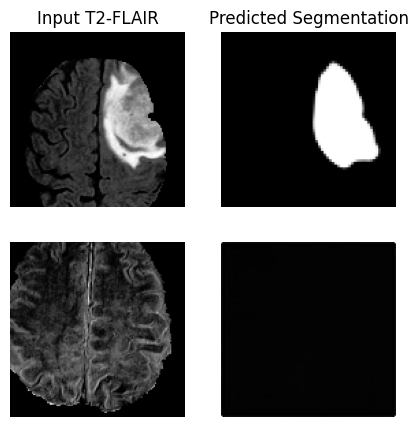

In [41]:
# Visualizing non-binarized segmentation outputs

fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs[0, 0].imshow(mr_images[0, 0], cmap='gray')
axs[0, 0].set_title("Input T2-FLAIR")
axs[0, 0].axis('off')
axs[0, 1].imshow(predicted_segmentations[0], cmap='gray')
axs[0, 1].set_title("Predicted Segmentation")
axs[0, 1].axis('off')
axs[1, 0].imshow(mr_images[1, 0], cmap='gray')
axs[1, 0].axis('off')
axs[1, 1].imshow(predicted_segmentations[1], cmap='gray')
axs[1, 1].axis('off')
plt.show()

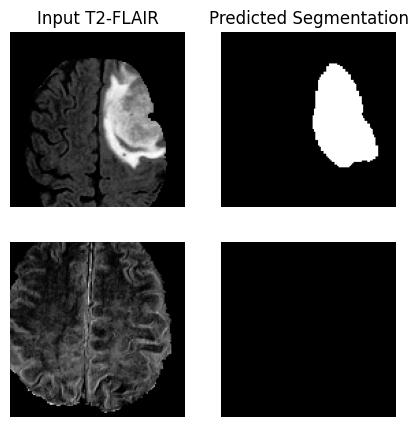

In [42]:
# Visualizing binarized segmentation outputs

predicted_segmentations[predicted_segmentations > 0.5] = 1
predicted_segmentations[predicted_segmentations <= 0.5] = 0

fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs[0, 0].imshow(mr_images[0, 0], cmap='gray')
axs[0, 0].set_title("Input T2-FLAIR")
axs[0, 0].axis('off')
axs[0, 1].imshow(predicted_segmentations[0], cmap='gray')
axs[0, 1].set_title("Predicted Segmentation")
axs[0, 1].axis('off')
axs[1, 0].imshow(mr_images[1, 0], cmap='gray')
axs[1, 0].axis('off')
axs[1, 1].imshow(predicted_segmentations[1], cmap='gray')
axs[1, 1].axis('off')
plt.show()

## Acquiring WSCM score
The WSCM score is used to approximate the quality of the segmentation in a weakly supervised fashion.

In [43]:
class WSCM:
  def __init__(self):
    self.l1_func = nn.L1Loss(reduction='none')

  def measure(self, original, variant, seg):
    if seg.sum() == 0:
        return 1

    return (self.l1_func(original, variant) * seg).sum() / seg.sum()

wscm = WSCM()

WSCM for image 0

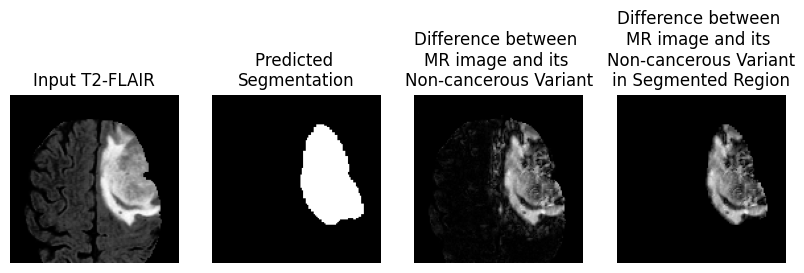

WSCM: 0.19051220637331004


In [44]:
fig, axs = plt.subplots(1, 4, figsize=(10, 10))
axs[0].imshow(mr_images[0, 0], cmap='gray')
axs[0].set_title("Input T2-FLAIR")
axs[0].axis('off')
axs[1].imshow(predicted_segmentations[0], cmap='gray')
axs[1].set_title("Predicted \nSegmentation")
axs[1].axis('off')
axs[2].imshow(example_reconstruction_maps[0, 0], cmap='gray', vmin=0, vmax=1)
axs[2].set_title("Difference between \nMR image and its \nNon-cancerous Variant")
axs[2].axis('off')
axs[3].imshow(example_reconstruction_maps[0, 0] * predicted_segmentations[0], cmap='gray', vmin=0, vmax=1)
axs[3].set_title("Difference between \nMR image and its \nNon-cancerous Variant\nin Segmented Region")
axs[3].axis('off')

plt.show()

# mr_images is of shape (N, 4, H, W), example_reconstruction_maps is of shape (N, 1, H, W), and predicted_segmentations is of shape (N, H, W)
  # Note that we're only using the FLAIR channel from the original MR image because the non-cancerous variants are generated based on the FLAIR channel
image0_measure = wscm.measure(mr_images[0:1, 0], example_reconstruction_maps[0:1, 0], predicted_segmentations[0:1])
print("WSCM:", image0_measure.item())

WSCM for image 1

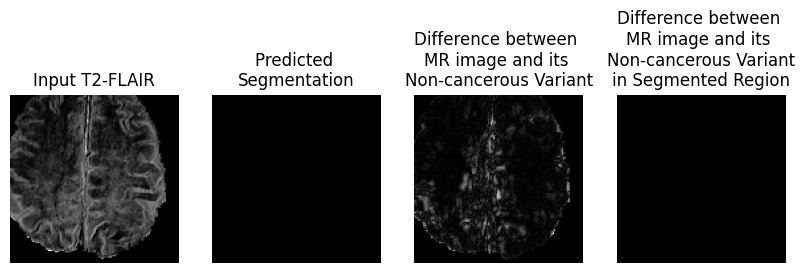

WSCM: 1


In [45]:
fig, axs = plt.subplots(1, 4, figsize=(10, 10))
axs[0].imshow(mr_images[1, 0], cmap='gray')
axs[0].set_title("Input T2-FLAIR")
axs[0].axis('off')
axs[1].imshow(predicted_segmentations[1], cmap='gray')
axs[1].set_title("Predicted \nSegmentation")
axs[1].axis('off')
axs[2].imshow(example_reconstruction_maps[1, 0], cmap='gray', vmin=0, vmax=1)
axs[2].set_title("Difference between \nMR image and its \nNon-cancerous Variant")
axs[2].axis('off')
axs[3].imshow(example_reconstruction_maps[1, 0] * predicted_segmentations[1], cmap='gray', vmin=0, vmax=1)
axs[3].set_title("Difference between \nMR image and its \nNon-cancerous Variant\nin Segmented Region")
axs[3].axis('off')

plt.show()

# mr_images is of shape (N, 4, H, W), reconstruction_maps is of shape (N, 1, H, W), and predicted_segmentations is of shape (N, H, W)
  # Note that we're only using the FLAIR channel from the original MR image because the non-cancerous variants are generated based on the FLAIR channel
image1_measure = wscm.measure(mr_images[1:2, 0], example_reconstruction_maps[1:2, 0], predicted_segmentations[1:2])
print("WSCM:", image1_measure)